# Get Hollister locations

#### Load Python tools and Jupyter config

In [1]:
%load_ext lab_black

In [2]:
import json
import requests
import pandas as pd
import geopandas as gpd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm, trange
import re
import numpy as np

In [3]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = None

## Read data

#### Snag a list of ZIP Codes

In [4]:
zips = gpd.read_file("/Users/mstiles/data/gis/demogragrphics_zips.geojson")

In [5]:
zips["lon"] = zips.centroid.map(lambda p: p.x)
zips["lat"] = zips.centroid.map(lambda p: p.y)

/var/folders/k0/l0l0k9f50w7cg_phqmhkhybm0000gx/T/ipykernel_5134/2182203394.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zips["lon"] = zips.centroid.map(lambda p: p.x)
/var/folders/k0/l0l0k9f50w7cg_phqmhkhybm0000gx/T/ipykernel_5134/2182203394.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zips["lat"] = zips.centroid.map(lambda p: p.y)


In [6]:
zips.columns = zips.columns.str.lower()

In [7]:
zips_slim = (
    (
        zips[["zip", "lon", "lat", "po_name", "state", "pop2012"]]
        .drop_duplicates()
        .copy()
    )
    .sort_values("pop2012", ascending=False)
    .reset_index(drop=True)
)

In [8]:
zips_slim.head()

,zip,lon,lat,po_name,state,pop2012
0,60629,-87.712757,41.775004,Chicago,IL,116508
1,79936,-106.292819,31.758769,El Paso,TX,113599
2,11368,-73.853184,40.749566,Corona,NY,107629
3,90011,-118.258749,34.007498,Los Angeles,CA,107268
4,90650,-118.082813,33.906985,Norwalk,CA,106750


#### Loop through the list to set a search radius in each state (takes ~20 mins)

In [9]:
headers = {
    "authority": "www.abercrombie.com",
    "accept": "application/json, text/javascript, */*; q=0.01",
    "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
}

In [10]:
data_list = []

for index, row in zips_slim.head(10).iterrows():
    lat_value = round(row["lat"], 5)
    long_value = round(row["lon"], 5)

    params = {
        "country": "US",
        "latitude": f"{lat_value}",
        "longitude": f"{long_value}",
        "radius": "200",
        "radiusUOM": "SMI",
    }

    response = requests.get(
        "https://www.hollisterco.com/api/ecomm/h-us/storelocator/search",
        params=params,
        headers=headers,
    )

    responses = response.json()["physicalStores"]
    for r in responses:
        responses_dict = {
            "storeNumber": r["storeNumber"],
            "name": r["name"],
            "address": r["addressLine"][0],
            "city": r["city"],
            "state": r["stateOrProvinceName"],
            "zip": r["postalCode"],
            "phone": r["telephone"],
            "latitude": r["latitude"],
            "longitude": r["longitude"],
            "etc": r["physicalStoreAttribute"],
        }
        data_list.append(responses_dict)

In [11]:
response.url

'https://www.hollisterco.com/api/ecomm/h-us/storelocator/search?country=US&latitude=40.64118&longitude=-74.01673&radius=200&radiusUOM=SMI'

In [12]:
src = pd.DataFrame(data_list)

#### Explode the nested list in the `etc` attribute column

In [13]:
data = src["etc"].apply(lambda x: [x])
flat_df = pd.json_normalize(data.explode(), sep="_")

In [14]:
result_df = pd.concat([src, flat_df], axis=1).drop(columns="etc")

#### Extract a couple values from it

In [15]:
result_df["brand"] = pd.json_normalize(result_df[7])["value"]
result_df["open_date"] = pd.to_datetime(
    pd.json_normalize(result_df[10])["value"].str.replace("N", "")
)

#### Clean dataframe

In [16]:
df = result_df[
    [
        "storeNumber",
        "name",
        "address",
        "city",
        "state",
        "zip",
        "phone",
        "latitude",
        "longitude",
        "brand",
        "open_date",
    ]
].copy()

In [17]:
df.head()

,storeNumber,name,address,city,state,zip,phone,latitude,longitude,brand,open_date
0,30647,Chicago Ridge,660 Chicago Ridge Mall,Chicago Ridge,IL,60415,708-346-0599,41.71899,-87.78252,HOL,2007-11-15
1,33564,Water Tower,"835 N Michigan Ave, Unit 5000",Chicago,IL,60611,312-284-1702,41.89812,-87.62400,HOL,NaT
2,53564,Water Tower,"835 N Michigan Ave, Unit 5000",Chicago,IL,60611,312-284-1702,41.89812,-87.62400,GH,NaT
3,31538,Orland Square,534 Orland Square Dr,Orland Park,IL,60462,708-349-0970,41.61980,-87.84830,HOL,2016-10-14
4,32092,Harlem Irving,4190 North Harlem Ave,Norridge,IL,60706,708-402-9027,41.95755,-87.80764,HOL,2023-06-02


#### There are many dupes

In [18]:
df = df.drop_duplicates(subset="storeNumber")

In [19]:
len(df)

104

#### Sometimes there are differently branded stores at same location (Hollister vs. Gilly Hicks), [like these two](https://www.hollisterco.com/shop/StoreLocator?storeId=10251&catalogId=10201&langId=-1), not dupes

In [20]:
df[df["address"] == "835 N Michigan Ave, Unit 5000"]

,storeNumber,name,address,city,state,zip,phone,latitude,longitude,brand,open_date
1,33564,Water Tower,"835 N Michigan Ave, Unit 5000",Chicago,IL,60611,312-284-1702,41.89812,-87.624,HOL,NaT
2,53564,Water Tower,"835 N Michigan Ave, Unit 5000",Chicago,IL,60611,312-284-1702,41.89812,-87.624,GH,NaT


---

## Aggregate

#### Counts by city

In [21]:
df_grouped = (
    df.groupby(["city", "state"])
    .agg({"storeNumber": "count"})
    .reset_index()
    .rename(columns={"storeNumber": "count"})
    .sort_values("count", ascending=False)
).reset_index(drop=True)

In [22]:
df_grouped.head(20)

,city,state,count
0,Glendale,CA,3
1,Oak Brook,IL,2
2,El Paso,TX,2
3,Tinton Falls,NJ,2
4,Schaumburg,IL,2
5,Paramus,NJ,2
6,Irvine,CA,2
7,Chicago,IL,2
8,Cherry Hill,NJ,2
9,Arcadia,CA,2


---

## Geography

#### Make a geodataframe from lon/lat

In [23]:
df_geo = df.copy()

In [24]:
gdf = gpd.GeoDataFrame(
    df_geo, geometry=gpd.points_from_xy(df_geo.longitude, df_geo.latitude)
).set_crs("epsg:4326")

<AxesSubplot: >

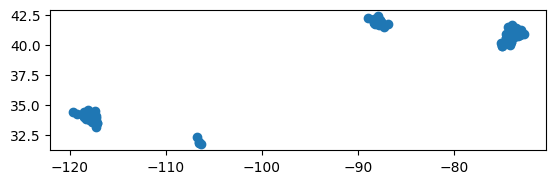

In [25]:
gdf.plot()

---

## Exports

#### CSV

In [26]:
df.to_csv("data/processed/hollister_locations.csv", index=False)

#### JSON

In [27]:
df.to_json("data/processed/hollister_locations.json", indent=4, orient="records")

#### GeoJSON

In [28]:
gdf.to_file("data/processed/hollister_locations.geojson", driver="GeoJSON")